# Методы Монте-Карло (ДЗ 4)

In [ ]:
#all imports here, please
import numpy as np
import scipy
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

В этом домашнем задании мы на практике поразбираемся, как можно использовать методы Монте-Карло для вычисления интегралов. Позади этой идеи целая наука, достойная отдельного курса, которую мы не в силах покрыть 1 неделей.

## Посчитать не вычислимый аналитически интеграл, 2.5 балла

Положим, мы хотим вычислить

$$
\int_{a}^b f(x) dx,
$$

который мы не можем посчитать руками (либо мы недостаточно искусны). В рамках одно(двух,трёх)мерного случая есть квадратурные формулы (например, метод трапеций),  но что делать, если мы хотим посчитать 100-мерный интеграл? В этом случае помогают методы Монте-Карло. Для простой иллюстрации мы ограничимся одномерным интегралом, но вы сможете при желании разобраться, как можно обобщить.

Усиленный закон больших чисел говорит, если дана последовательность незавсимых и одинаково распределённых величин с конечной диспресией $(\xi_n)$, то

$$
\frac{1}{n}\sum_{i=1}^n \xi_i \to_{\text{п.н.}}\mathbb{E}[\xi_1].
$$

Если мы сможем представить искомый интеграл как матожидание некоторой случайной величины, которую мы дёшево можем семплировать, то мы можем использовать УЗБЧ, для того чтобы приближённо посчитать интеграл, причём скорость сходимости ($1/\sqrt{n}$) не зависит даже от размерности $x$.

### Равномерное распределение

Плотность равномерного распределения на отрезке $[a,b]$ известна. Давайте присмотримся к интегралу:

$$
\int_{a}^b f(x) dx = \frac{b-a}{b-a}\int_{a}^b f(x) dx = (b-a) \mathbb{E}[f(U)], \quad U \sim Uniform([a,b]).
$$

На основе этого можно предложить метод.

#### Метод интегрирования на основе равномерного распределения (0.5 балла)

Реализуйте метод интегрирования, используя библиотеку numpy.


In [ ]:
import random


def uniformMC(func, a, b, n):
    sum = 0
    for _ in range(n):
        x = random.uniform(a, b)
        sum += func(x)
    est = (b - a) * sum / n
    return est
    

def f(x):
    return x**2

In [ ]:
import random

# простой пример для самопроверки
a=0
b=2
ns = np.arange(10,1e7,50000).astype("int64")
intTrue = uniformMC(f, a, b, 10000000) # вычислите истинный интеграл

res = np.zeros([len(ns)])
for i in tqdm.tqdm(np.arange(len(ns))):#обёртка tqdm, чтобы рисовать прелоадер
    res[i]=uniformMC(f,a,b,ns[i])

100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


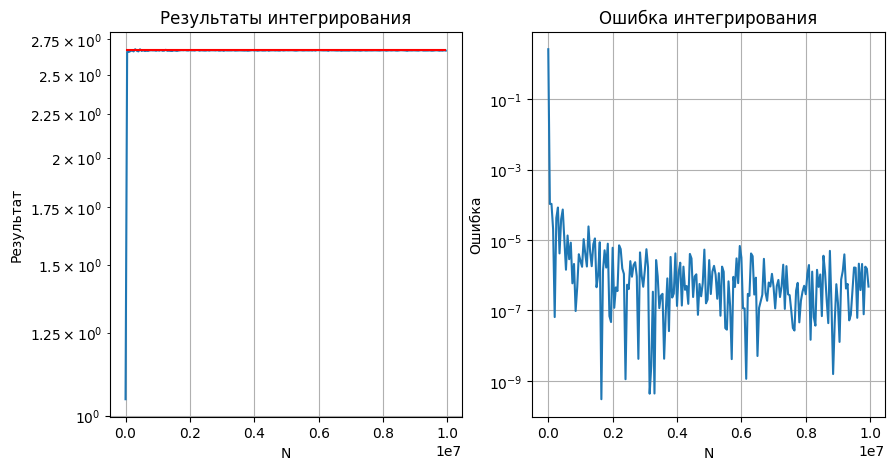

In [ ]:
#сопоставим с известным для самопроверки

f, (ax,ax2) = plt.subplots(1,2,figsize=(10,5))

ax.set_title("Результаты интегрирования")
ax.set_xlabel("N")
ax.set_ylabel("Результат")
#ax.set_yscale("log")#для лучшей различимости быстро убывающих вещей
ax.grid()

ax.plot(ns,res)
ax.hlines(y=intTrue,xmin=ns[0],xmax=ns[-1], colors="red")


ax2.set_title("Ошибка интегрирования")
ax2.set_xlabel("N")
ax2.set_ylabel("Ошибка")
ax2.set_yscale("log")#для лучшей различимости быстро убывающих вещей
#ax2.set_xscale("log")#для лучшей различимости быстро убывающих или растущих вещей
ax2.grid()

ax2.plot(ns,(res-intTrue)**2)

Вроде работает, если у вас сходится до ошибки $10^{-7}$.

### Скорость сходимости (0.3 балла)

Какая скорость сходимости? Попробуйте посчитать сами, предположив, что ошибка
$$
Err_n = cn^p + \varepsilon_n,
$$
и оценив $p$ по данным, используя метод наименьших квадратов. Подсказка: возьмите логарифм от левой и правой части, а потом методом наименьших квадратов оцените коэффициент при $\ln n$. Нарисуйте рядом с ошибками линию $f(n) = cn^p$, используя оценённые значения.

Для этого вам понадобится, например, np.linalg.lstsq.

In [ ]:
lners = np.log(np.array((res-intTrue)**2))
lnns = np.log(ns)

#соберите матрицу для lstsq
# [logN, 1]... например, шейпа (200,2) (первая размерность -- количество ns, которые вы взяли выше)
A = np.vstack([lnns, np.ones_like(lnns)]).T

#раскомментируйте!
alpha = np.linalg.lstsq(A, lners)[0]

<ipython-input-5-224ab34b31a7>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha = np.linalg.lstsq(A, lners)[0]


Модель logErr_n = -1.0859448659189346log(n) + 1.9949288679190436


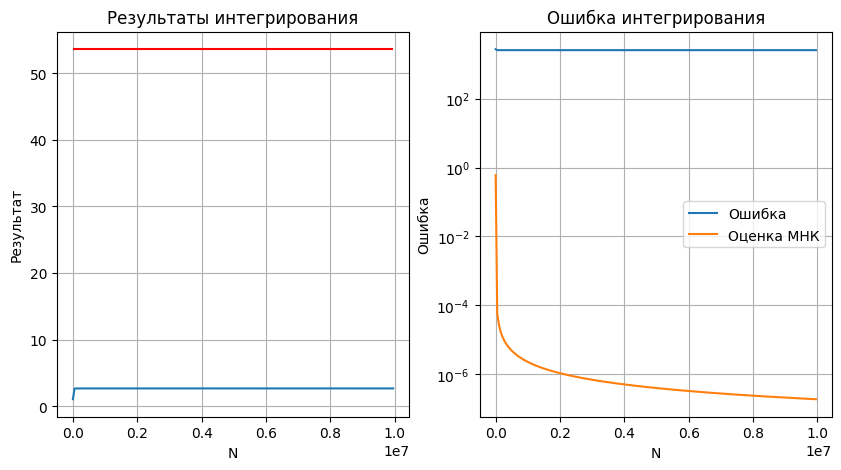

In [ ]:
#сопоставим с известным для самопроверки

f, (ax,ax2) = plt.subplots(1,2,figsize=(10,5))

ax.set_title("Результаты интегрирования")
ax.set_xlabel("N")
ax.set_ylabel("Результат")
#ax.set_yscale("log")#для лучшей различимости быстро убывающих вещей
ax.grid()

ax.plot(ns,res)
ax.hlines(y=intTrue,xmin=ns[0],xmax=ns[-1], colors="red")


ax2.set_title("Ошибка интегрирования")
ax2.set_xlabel("N")
ax2.set_ylabel("Ошибка")
ax2.set_yscale("log")#для лучшей различимости быстро убывающих вещей
#ax2.set_xscale("log")#для лучшей различимости быстро убывающих или растущих вещей
ax2.grid()

ax2.plot(ns,(res-intTrue)**2)
print(f"Модель logErr_n = {alpha[0]}log(n) + {alpha[1]}")
ax2.plot(ns,np.exp(alpha[1])*ns**alpha[0])
ax2.legend(["Ошибка", "Оценка МНК"])

Напишите, чему равно оценённое $p$ (скорость сходимости) и поясните свой ответ.

Скорость сходимости является коэффициентом alpha = -1.128921042187215$.
alpha стремится к -1, поэтому скорость сходимости будет более быстрой

#### Верхняя оценка для ошибки (0.5 балла)

Мы можем использовать известные нам предельные законы вместе с некоторыми обычными неравенствами, чтобы получить оценки для ожидаемой ошибки, например, в форме
$$
\mathbb{E}[(I_n - I)^2] = \mathbb{E}\left[\left( (b-a)\frac{1}{n}\sum_{i=1}^n f(X_i) - \int_{a}^b f(x) dx\right)^2\right].
$$
На языке вероятности выглядит очень компактно.

Докажите, что
$$
\mathbb{E}[(I_n - I)^2] = (b-a)^2\frac{D[f(X)]}{n}, ~ X \sim Uniform[a,b].
$$

$$ РЕШЕНИЕ  $$
Давайте применим Центральную Предельную Теорему (ЦПТ) к нашей сумме $$\sum_{i=1}^n f(X_i)$$, мы можем утверждать, что (при n, стремящемся к бесконечности) наша сумма будет приближаться к нормальному распределению со средним значением $${nE[f(X)]} = n(a + b) / 2$$ и дисперсией $${nD[f(X)]} = (b - a)^2 / 12$$.
В терминах дисперсии f(x):
$$
\begin{aligned}
\mathbb{E}[(I_n - I)^2] & = \mathbb{E}\left[\left( (b-a)\frac{1}{n}\sum_{i=1}^n f(X_i) - \int_{a}^b f(x) dx\right)^2\right] \\
& = \frac{(b-a)^2}{n^2} \mathbb{E}\left[\left(\sum_{i=1}^n f(X_i) - n\int_{a}^b f(x) dx\right)^2\right] \\
& = \frac{(b-a)^2}{n^2} \cdot nD[f(X)] \\
& = (b-a)^2\frac{D[f(X)]}{n}
\end{aligned}
$$

Таким образом, мы доказали, что $$\mathbb{E}[(I_n - I)^2] = (b-a)^2\frac{D[f(X)]}{n}$$ для X, равномерно распределенной между a и b

#### Вероятностная оценка для ошибки (0.5 балла)

С другой стороны, центральная предельная теорема позволяет найти асимптотическое распределение $I_n$. Напишите, какое распределение при больших $n$ будет иметь $I_n$ и найдите вероятность $\mathbb{P}(\vert I_n - I \vert<\varepsilon)$; напишите, как её посчитать для любых $n,\varepsilon$.


$$\mathbf{РЕШЕНИЕ}$$
Когда значение $n$ становится большим, выполняется приближение $$\frac{I_n - \mathbb{E}[I_n]}{\sqrt{\mathbb{D}[I_n]}} \sim N(0,1)$$. Это означает, что преобразовав $P(|I_n| < ϵ)$ в функцию Лапласа, мы сможем точно вычислить её значение. Давайте сделаем это:

$$P(|I_n - I| < ϵ) = P\left(\frac{|I_n - I|}{\sqrt{\mathbb{D}[|I_n|]}} < \frac{\epsilon}{\sqrt{\mathbb{D}[|I_n|]}}\right) = P\left(-\frac{\epsilon}{\sqrt{\mathbb{D}[|I_n|]}} < \frac{I_n - I}{\sqrt{\mathbb{D}[|I_n|]}} < \frac{\epsilon}{\sqrt{\mathbb{D}[|I_n|]}}\right) = Ф_0\left(\frac{\epsilon}{\sqrt{\mathbb{D}[|I_n|]}}\right) - Ф_0\left(-\frac{\epsilon}{\sqrt{\mathbb{D}[|I_n|]}}\right) = Ф_0\left(\frac{\epsilon}{\sqrt{\mathbb{D}[|I_n|]}}\right) + Ф_0\left(\frac{\epsilon}{\sqrt{\mathbb{D}[|I_n|]}}\right) = 2Ф_0\left(\frac{\epsilon}{\sqrt{\mathbb{D}[|I_n|]}}\right)$$

Подставив значение $n$ и $ϵ$ внутрь скобок, мы можем найти значений функции Лапласа в таблице.



Напишите, как подобрать $\varepsilon$, чтобы вероятность $\mathbb{P}(\vert I_n - I\vert<\varepsilon)=p$, где $p$ вы задаёте сами в интервале от 0 до 1. Подсказка: вспомните, что такое квантиль.

$$ ОТВЕТ $$
Для подбора $\varepsilon$ такого, что вероятность $\mathbb{P}(\vert I_n \vert<\varepsilon)$ равна $p$, мы можем воспользоваться квантилем.

Квантиль уровня $p$ это такое значение $\varepsilon_p$, что вероятность $\mathbb{P}(\vert I_n \vert<\varepsilon_p)$ равна $p$. Другими словами, это значение, которое делит распределение случайной величины $I_n$ на две части: $p$ процентов значений будет меньше $\varepsilon_p$, а $(1-p)$ процентов значений будет больше $\varepsilon_p$.
Чтобы сделать это, необходимо в таблице значений функции Лапласа найти значение x, при котором $Ф_0(x) = p/2$. После чего решить уравнение $$x = \frac{\epsilon}{\sqrt{\mathbb{D}[|I_n|]}}$$

#### Расчёты для разных функций (0.7 балла)

Исходя из своего номера в ведомости выберите себе функцию, считая остаток от деления вашего id на количество задач и прибавив +1. Посчитайте интеграл для всех $n$ от $10^3$ до $5*10^6$ c шагом $50000$, нарисуйте график ошибки $(I_n-I)^2$ в логарифмических осях, а также вычислите эмпирически скорость сходимости (как выше). Приведите

1. Что-то привычное
$$
1) f(x)= x^{1/5} sin(0.8x-2) + 25x, ~a=3, b=15
$$
$$
2) f(x)= e^{0.3x+0.002x^4}cos(0.7x) - 3x^2 + 4, ~a=3, b=5
$$
$$
3) f(x)= e^{0.3x} + 4 e^{-x^2/4}x^3 + 4, ~a=3, b=10
$$
$$
4) f(x)= e^{0.3x} + 4 e^{-x^2/4}x^3 + 4, ~a=2, b=6
$$
$$
5) f(x)= e^{-0.8x + 4cos^2(x)} + 2 e^{-x^2/4}x^2 - 3, ~a=1, b=5
$$
2. Что-то менее очевидное (вам понадобится модуль scipy.special, за математикой см. [sinc](https://en.wikipedia.org/wiki/Sinc_function), [Si](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%82%D0%B5%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D1%81%D0%B8%D0%BD%D1%83%D1%81),  [Ci](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%82%D0%B5%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%BA%D0%BE%D1%81%D0%B8%D0%BD%D1%83%D1%81), [функции Бесселя](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8_%D0%91%D0%B5%D1%81%D1%81%D0%B5%D0%BB%D1%8F) )
$$
1) f(x) = sinc(x)cos(5x)x^3, ~ a=0.2, b=2
$$
$$
2) f(x) = Si(x)cos(2x)x^3, ~ a=0.2, b=2
$$
$$
3) f(x) = Сi(x)sin(3x)x^3, ~ a=0.2, b=3
$$
$$
4) f(x) = J_{0}(x)cos(3x)e^{2x}, ~ a=0.2, b=4
$$
$$
5) f(x) = J_{1}(x)sin(6x)e^{-0.1x}, ~ a=0.2, b=4
$$

ВАШ КОД, ВЫКЛАДКИ и ПОЯСНЕНИЯ ЗДЕСЬ

In [ ]:
def find_and_build(func, a, b, intTrue):
  # простой пример для самопроверки
  ns = np.arange(10**3, 5 * 10**6, 50000).astype("int64")

  result = np.zeros([len(ns)])
  for index in tqdm.tqdm(np.arange(len(ns))):
      result[i]=uniformMC(func,a,b,ns[index])

  liners = np.log(np.array((result-intTrue)**2))
  lines = np.log(ns)

  A_symbol = np.vstack([lines, np.ones_like(lines)]).T

  alpha = np.linalg.lstsq(A_symbol, liners)[0]

  f, (ax,ax2) = plt.subplots(1,2,figsize=(10,5))

  ax.set_title("Integration result")
  ax.set_xlabel("N")
  ax.set_ylabel("Result")
  ax.grid()

  ax.hlines(y=intTrue,xmin=ns[0],xmax=ns[-1], colors="red")
  ax.plot(ns,result)

  ax2.set_title("Integration error")
  ax2.set_xlabel("N")
  ax2.set_ylabel("Error")
  ax2.set_yscale("log")
  ax2.set_xscale("log")
  ax2.grid()

  ax2.plot(ns,(result-intTrue)**2)
  print(f"A Model logErr_n = {alpha[0]}log(n) + {alpha[1]}")
  ax2.plot(ns,np.exp(alpha[1])*ns**alpha[0])
  ax2.legend(["Error", "OLS valuation"])
  print(f"The rate of convergence is{alpha[0]}")

$$ f(x)= e^{0.3x} + 4 e^{-x^2/4}x^3 + 4, ~a=2, b=6 $$

<IPython.core.display.Latex object>

100%|██████████| 100/100 [01:23<00:00,  1.19it/s]
<ipython-input-11-99c8afe65f88>:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha = np.linalg.lstsq(A, lners)[0]


Модель logErr_n = -1.1701395139953061log(n) + 6.6008894022722995
Скорость интегрирования равна -1.1701395139953061


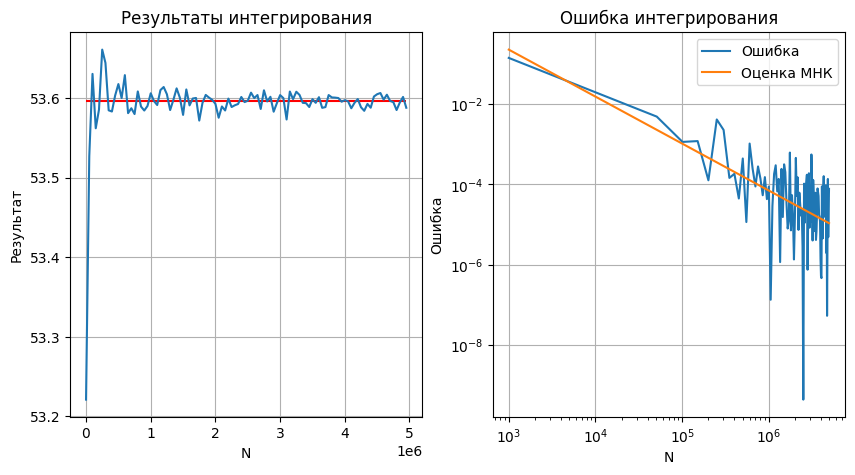

In [ ]:
#Вариант 18 - задача 4
import sympy
from IPython.display import Math, Latex

def f1(x, isSympy = False):
  if(isSympy):
    return sympy.exp(0.3 * x) + 4 * sympy.exp(-x**2/4) * x**3 + 4
  return np.exp(0.3 * x) + 4 * np.exp(-x**2/4) * x**3 + 4

a = 2
b = 6

x = sympy.Symbol('x')
func = f1(x, True)
display(Latex(f"Function\ {sympy.latex(func)}"))
intTrue = float(sympy.integrate(func, (x, a, b)).evalf())

find_and_build(f1, a, b, intTrue)

$$ f(x) = J_{0}(x)cos(3x)e^{2x}, ~ a=0.2, b=4 $$

In [ ]:
def find_and_build2(func, a, b):
  # простой пример для самопроверки
  new_value = np.arange(10**3, 5 * 10**6, 50000).astype("int64")

  result = np.zeros([len(new_value)])
  for index in tqdm.tqdm(np.arange(len(new_value))):
      result[index]=uniformMC(func,a,b,new_value[index])

  liners = np.log(np.array((result-intTrue)**2))
  lines = np.log(new_value)

  A_symbol = np.vstack([lines, np.ones_like(lines)]).T

  alpha = np.linalg.lstsq(A_symbol, liners)[0]

  f, (ax,ax2) = plt.subplots(1,2,figsize=(10,5))

  ax.set_title("Integration result")
  ax.set_xlabel("N")
  ax.set_ylabel("Result")
  ax.grid()

  ax.plot(new_value,result)

  ax2.set_title("Integration error")
  ax2.set_xlabel("N")
  ax2.set_ylabel("ERROR")
  ax2.set_yscale("log")
  ax2.set_xscale("log")
  ax2.grid()

  print(f"Model logErr_n = {alpha[0]}log(n) + {alpha[1]}")
  ax2.plot(new_value,np.exp(alpha[1])*new_value**alpha[0])
  ax2.legend(["OLS valuation"])
  print(f"The rate of convergence is {alpha[0]}")

100%|██████████| 100/100 [11:03<00:00,  6.63s/it]
<ipython-input-32-5a137b788b54>:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha = np.linalg.lstsq(A, lners)[0]


Модель logErr_n = 0.018597706177949133log(n) + 8.308578870698023
Скорость интегрирования равна 0.018597706177949133


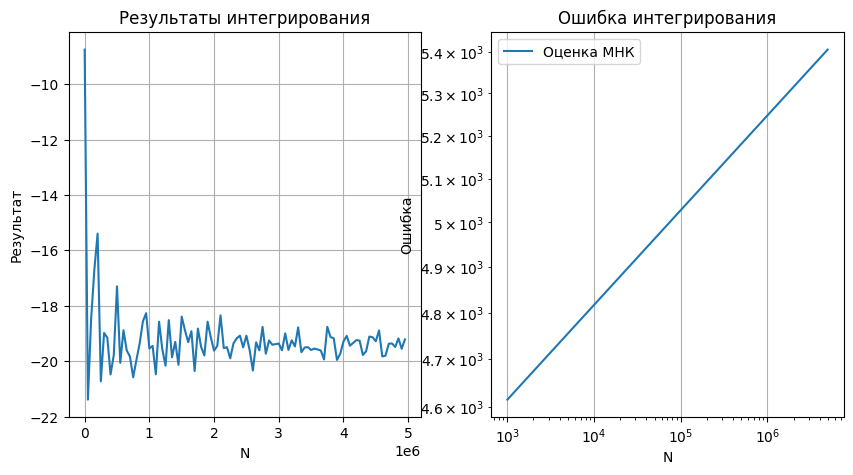

In [ ]:
def f2(x):
  return scipy.special.jn(0, x) * np.cos(3 * x) * np.exp(2 * x)

a = 0.2
b = 4
find_and_build2(f2, a, b)